# Note
* **Objective**: predict the covid test results
* The major aim is to optimize the **recall** (few false negative, FN: positive (covid-infected) cases wrongly predicted as negative)
* For most classification algorithms, only 10,000 rows of data is loaded for the sake of modeling speed
* Many lines of script in this notebook are taken from [Metis bootcamp](https://www.thisismetis.com/) teaching materials

# - - - Part 1: Prepare data - - -

# Load packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import itertools
import warnings
warnings.filterwarnings("ignore")

# for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)
pd.options.display.max_rows = 500 # display max rows
# pd.options.display.float_format = '{:.2f}'.format #supress scientific notation

# display full output in Jupyter, not only last result.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# sklearn - data preparation
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# sklearn - classification models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

from mlxtend.classifier import StackingClassifier

# evaluation metrics
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.model_selection import learning_curve, GridSearchCV

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# from plot import *

# plt.figure(figsize=(12,12), dpi=200)

In [2]:
import sklearn
import sys
import matplotlib

libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd), ('Sklearn', sklearn))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.7.1 (default, Oct 28 2018, 08:39:03) [MSC v.1912 64 bit (AMD64)] 

Matplotlib Version: 3.1.3
Numpy Version: 1.20.1
Pandas Version: 1.2.4
Sklearn Version: 0.24.1


# Data preparation
Here are some variables and data that will be used throughout this script
* `df_model`, `X`, `y`: cleaned dataframe
* `X_train`, `T_test`, `y_train`, `y_test`: split and scaled dataset for modeling
* `df_train`=`X_train`+`y_train`,  `df_test`=`X_test`+`y_test`
* `col_X`, `col_y`: columns for features and target

## df_model
* load the cleaned dataset and save as `df_model` for future use
* requirement: first N-1 columns as features, the last Nth column as the target

In [3]:
## - - - Covid dataset - - -
df = pd.read_pickle('data/' + 'df_covid_100000rows.pkl')
# df = pd.read_pickle('data/' + 'df_covid_100000rows_2020.3.pkl')
# df = pd.read_pickle('data/' + 'df_covid_100000rows_2020.9.pkl')
df = df.sample(10000) # load only 10000 rows for time-saving

print(df.shape)

df = df.reset_index(drop = True)

df_model = df

df.head()

(10000, 10)


,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad,corona_result
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [4]:
df = df_model

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   cough                   10000 non-null  int32
 1   fever                   10000 non-null  int32
 2   sore_throat             10000 non-null  int32
 3   shortness_of_breath     10000 non-null  int32
 4   head_ache               10000 non-null  int32
 5   age_60_and_above        10000 non-null  int64
 6   gender                  10000 non-null  int64
 7   contact_with_confirmed  10000 non-null  int64
 8   abroad                  10000 non-null  int64
 9   corona_result           10000 non-null  int64
dtypes: int32(5), int64(5)
memory usage: 586.1 KB


In [5]:
# value_counts for all columns, only works for pandas > 1.1.0

df = df_model

cat_cols = df.columns.tolist()
(pd.DataFrame(
    df[cat_cols]
    .melt(var_name='column', value_name='value')
    .value_counts())
.rename(columns={0: 'counts'})
.sort_values(by=['column', 'counts']))
# .reset_index()

counts
column                 value        
abroad                 1         131
                       0        9869
age_60_and_above       1        1339
                       0        8661
contact_with_confirmed 1         681
                       0        9319
corona_result          1         925
                       0        9075
cough                  1         479
                       0        9521
fever                  1         370
                       0        9630
gender                 1        4817
                       0        5183
head_ache              1         231
                       0        9769
shortness_of_breath    1          39
                       0        9961
sore_throat            1         128
                       0        9872

## X/y split, `col_X`, `col_y`
* `col_X` and `col_y` will be used through out this script for the classification training
* specific format for the `df_model`: totally N columns, first N-1 columns for feature and right-most column for target

In [6]:
df = df_model

col_X = list(df.columns)[0:-1]
col_y = list(df.columns)[-1:]

print('features:', col_X)
print('target:', col_y)

X = df[col_X]
y = df[col_y]

feature_names = col_X
target_names = col_y
target_values = list(df[col_y[0]].unique())

# check target values
df[col_y[0]].value_counts(normalize = False)
df[col_y[0]].value_counts(normalize = True)

features: ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'contact_with_confirmed', 'abroad']
target: ['corona_result']


0    9075
1     925
Name: corona_result, dtype: int64

0    0.907
1    0.092
Name: corona_result, dtype: float64

## Train/test/holdout split (`X_train`, `y_train`, `df_train`)
* *Train* - data used for training the model
* *Test* - data used for validating the model performance (accuracy/recall/precision/f1, metrics, ROC/AUC)
* *Holdout* - data will be never touched during the modeling and used at the very end to examine the performance of the final model

In [7]:
# split X and y into training and testing sets
# X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

print('shapes of X data frames (train-test-holdout):', X_train.shape, X_test.shape, X_holdout.shape)
print('shapes of y data frames (train-test-holdout):', y_train.shape, y_test.shape, y_holdout.shape)

shapes of X data frames (train-test-holdout): (8000, 9) (1000, 9) (1000, 9)
shapes of y data frames (train-test-holdout): (8000, 1) (1000, 1) (1000, 1)


## Scaling (`X`, `X_train`, `X_test`, `X_holdout`)

In [8]:
# transform as numpy array and transfer back to the datafram
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
scaler = MinMaxScaler()

# Kim: note that we should use fit_transform for the X_train and only transform for the X_test
X_train_ScaledArray = scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(X_train_ScaledArray)
X_train.columns = col_X

X_test_ScaledArray = scaler.transform(X_test.values)
X_test = pd.DataFrame(X_test_ScaledArray)
X_test.columns = col_X

# we use the same scaler for the holdout data and will only use it again at the every end
X_holdout_ScaledArray = scaler.transform(X_holdout.values)
X_holdout = pd.DataFrame(X_holdout_ScaledArray)
X_holdout.columns = col_X

# X is the entire feature dataset
X_ScaledArray = scaler.fit_transform(X.values)
X = pd.DataFrame(X_ScaledArray)
X.columns = col_X

# save df_train and df_test for some future tests
df_train = X_train.copy()
df_train[col_y] = y_train.copy()
df_test = X_test.copy()
df_test[col_y] = y_test.copy()

# reset.index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# this are non-modified files, which can be used for additional modeling work
X_copy, y_copy = X, y
X_train_copy, X_test_copy, X_holdout_copy = X_train, X_test, X_holdout
y_train_copy, y_test_copy, y_holdout_copy  = y_train, y_test, y_holdout

In [9]:
print('shapes of X data frames (train-test-holdout):', X_train.shape, X_test.shape, X_holdout.shape)
print('shapes of y data frames (train-test-holdout):', y_train.shape, y_test.shape, y_holdout.shape)

shapes of X data frames (train-test-holdout): (8000, 9) (1000, 9) (1000, 9)
shapes of y data frames (train-test-holdout): (8000, 1) (1000, 1) (1000, 1)


## quick check

In [10]:
# print the type
print(type(X), type(y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [11]:
# print the shapes of X and y
print(X.shape, y.shape)

(10000, 9) (10000, 1)


In [12]:
# print the shapes of the new X objects
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 9) (1000, 9) (8000, 1) (1000, 1)


In [13]:
# print the shapes of the data frames
print(df_train.shape, df_test.shape)

(8000, 10) (1000, 10)


In [14]:
X_train.head()
y_train.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,corona_result
0,0
1,0
2,0
3,0
4,0


In [15]:
X_train.describe()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad
count,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000,8000.000
mean,0.048,0.038,0.013,0.005,0.023,0.137,0.482,0.069,0.013
std,0.214,0.192,0.114,0.068,0.151,0.344,0.500,0.253,0.114
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
max,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [16]:
print('shapes of X data frames (train-test-holdout):', X_train.shape, X_test.shape, X_holdout.shape)
print('shapes of y data frames (train-test-holdout):', y_train.shape, y_test.shape, y_holdout.shape)

shapes of X data frames (train-test-holdout): (8000, 9) (1000, 9) (1000, 9)
shapes of y data frames (train-test-holdout): (8000, 1) (1000, 1) (1000, 1)


In [17]:
y_train[col_y[0]].value_counts()

0    7265
1     735
Name: corona_result, dtype: int64

# - - - Part 2: Modeling - - -

# Dummy model ...

Covid data
* Dummy model gives a good accuracy (~ 80%), due to the class imbalance (target: 10% positive and 90% negative)
* The low recall (~ 8%), precision, and f1 scores indicate the limited predictability of the dummy model

In [18]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='stratified') #most_frequent
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)

confusion_matrix(y_test, y_pred)

print('accuracy:', round(accuracy_score(y_test, y_pred), 3))
print('precision:', round(precision_score(y_test, y_pred), 3))
print('recall:', round(recall_score(y_test, y_pred), 3))
print('f1:', round(f1_score(y_test, y_pred), 3))

DummyClassifier(strategy='stratified')

array([[824,  84],
       [ 81,  11]], dtype=int64)

accuracy: 0.835
precision: 0.116
recall: 0.12
f1: 0.118


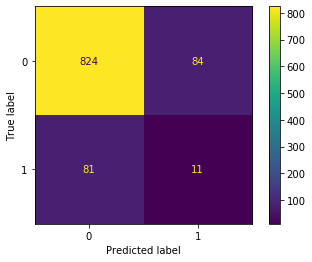

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

# Rapid tests - a few models
* Mostly from my previous script on the soccer classification project
* Simply using the default set-up in the sklearn
* Can be slow if the data has excessive features/columns or observations/rows

## Metrics & Scores

For covid data
* The idea of this section is to just test common models with default parameters. We will tune hyper-parameters later.
* Not surprisingly, due to the class imbalance, the accuracy is > 90% for most models.
* The key metric, recall, is generally as low as 0.6 for most models (we will optimize recall later)
* *NaiveBayes*: note that we should use *BernoulliNB* considering features are binary (0 and 1) and not continuous (*GaussianNB* is for continuous features)

In [20]:
# get the scores from models

df_score = pd.DataFrame()

mydict_models =  {
    'Logistic': LogisticRegression(), 
    'KNN': KNeighborsClassifier(), 
    'NaiveBayes': BernoulliNB(),
    'SVC': SVC(), 
    'Tree': DecisionTreeClassifier(), 
    'Forest': RandomForestClassifier()
}

for index, key in enumerate(mydict_models.keys()):
    
    model_name = key
    model = mydict_models[key]

    model.fit(X_train, y_train);
    y_pred = model.predict(X_test)
        
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    data_onemodel = [model_name, accuracy, precision, recall, f1]
    
    df_temp = pd.DataFrame([data_onemodel])
    df_score = pd.concat([df_score, df_temp])

df_score.columns = ['model', 'accuracy', 'precision', 'recall', 'f1']

df_score.head()

LogisticRegression()

KNeighborsClassifier()

BernoulliNB()

SVC()

DecisionTreeClassifier()

RandomForestClassifier()

,model,accuracy,precision,recall,f1
0,Logistic,0.924,0.722,0.283,0.406
0,KNN,0.926,0.661,0.402,0.500
0,NaiveBayes,0.925,0.681,0.348,0.460
0,SVC,0.932,0.676,0.500,0.575
0,Tree,0.934,0.710,0.478,0.571


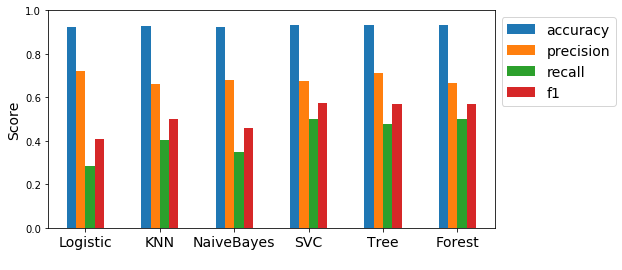

In [21]:
df = df_score

df[['model','accuracy', 'precision', 'recall', 'f1']].plot(x='model', kind='bar', figsize=(8, 4), legend=False)
plt.legend(bbox_to_anchor=(1,1), ncol = 1, fontsize = 14)
plt.ylim([0.0, 1])
plt.ylabel('Score', fontsize = 14)
plt.xlabel('model', alpha=0)
plt.xticks(rotation=0, fontsize = 14)
plt.show();

## Train-test error
* Loop through a few models and check the trends of train/test error
* Why doing this? Check 1) the effect of training size (sensitivity) and 2) under/over fitting

Covid data
* It looks that train/test errors converge very quick (even a small dataset would be sufficient to construct a reasonably OK model)

Logistic
KNN
NaiveBayes
SVC
Tree
Forest


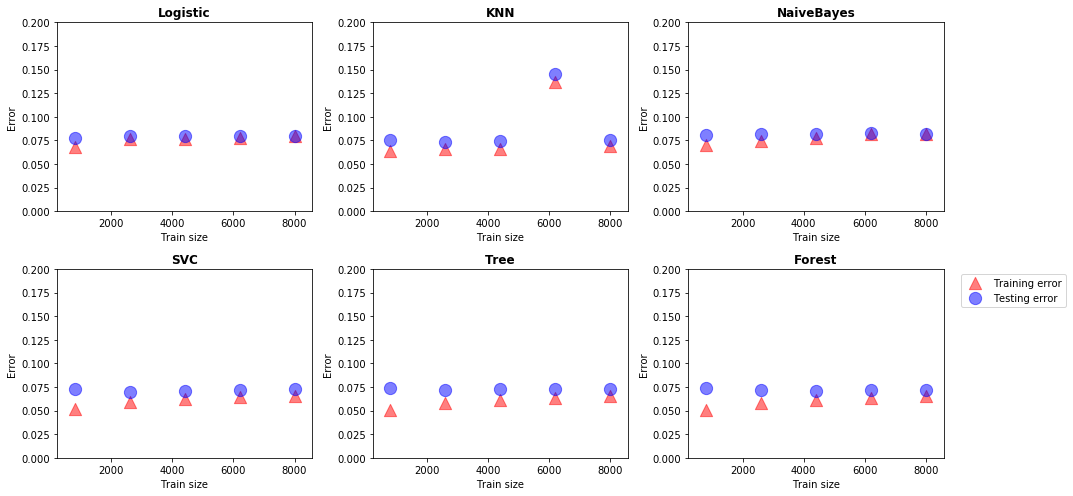

In [22]:
plt.figure(figsize=(15,7))

for index, value in enumerate(mydict_models.keys()):
    
    model_name = value
    model = mydict_models[value]
    print(model_name)
    
    plot_id = '23{}'.format(index+1)
    plt.subplot(plot_id)
    plt.title('{}'.format(model_name), weight='bold')

    train_sizes, train_scores, valid_scores = learning_curve(model, X, y)
    train_err = 1- train_scores
    ts_err = 1- valid_scores
    
    train_cv_err = np.mean(train_err, axis=1)
    test_cv_err = np.mean(ts_err, axis=1)
    
    plt.scatter(train_sizes, train_cv_err, marker= '^', color='red', s = 150, label = 'Training error', alpha = 0.5)
    plt.scatter(train_sizes, test_cv_err, marker='o', color='blue', s =150, label = 'Testing error', alpha = 0.5)

    plt.xlabel('Train size')
    plt.ylabel('Error')
    plt.ylim([0,0.2])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=1)
plt.tight_layout()

plt.show();

## Confusion matrix

In [23]:
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Logistic
KNN
NaiveBayes
SVC
Tree
Forest


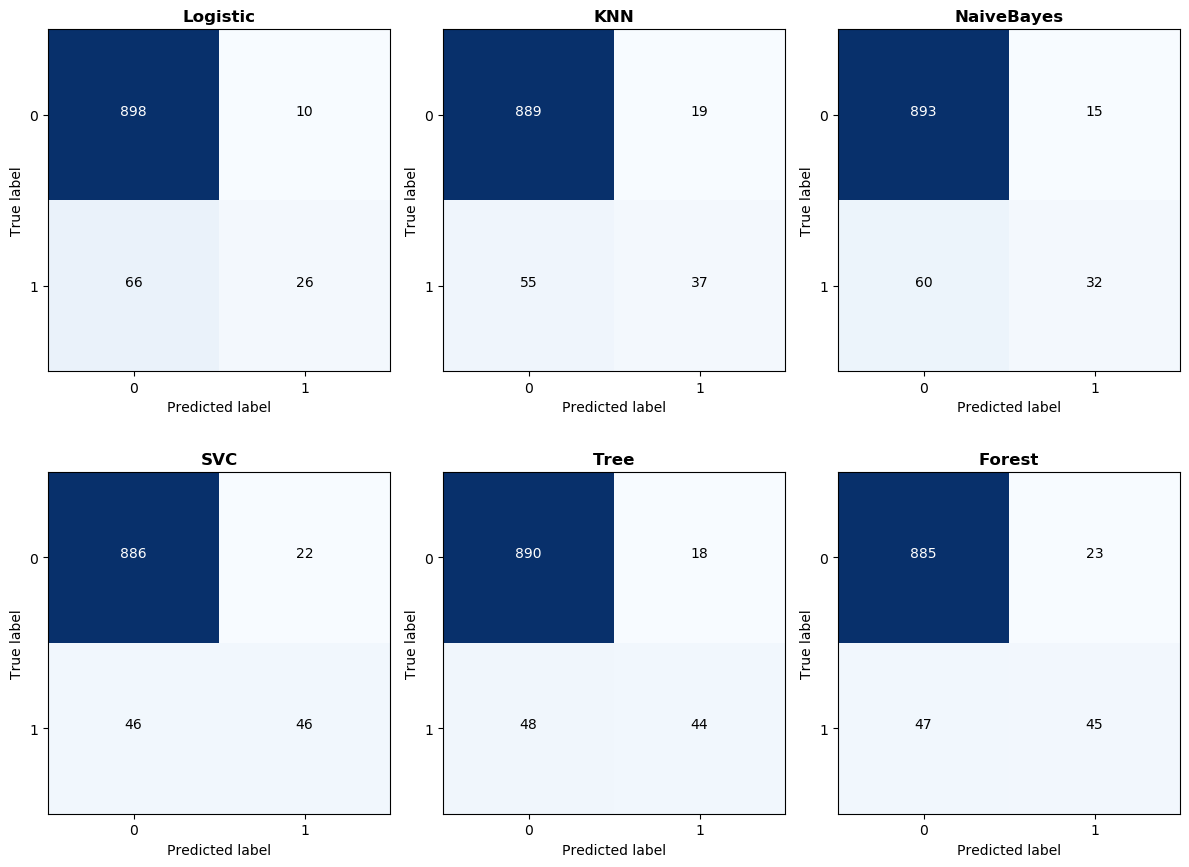

In [24]:
plt.figure(figsize=(12,9), dpi=100)

for index, value in enumerate(mydict_models.keys()):
    model_name = value
    model = mydict_models[value]
    print(model_name)
    
    plot_id = '23{}'.format(index+1)
    plt.subplot(plot_id)
    plt.title('{}'.format(model_name), weight='bold')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test,y_pred)
    
    plot_confusion_matrix(cm,[0,1])

plt.tight_layout()
plt.show();

# - - - Part 3: Model tuning - - -

# KNN

Covid data
* Now, let us look into more details of KNN
* We tune the model by changing K (and other hyper-parameters) to optimize the recall score
* Best recall when K = 30

## Tuning - a simple loop ....

In [25]:
df_score_knn = pd.DataFrame()

for n in range(1, 70, 10):
    model = KNeighborsClassifier(n_neighbors=n)
    model_name = int(n)
    
    model.fit(X_train, y_train);
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    data_onemodel = [model_name, accuracy, precision, recall, f1]
    
    df_temp = pd.DataFrame([data_onemodel])
    df_score_knn = pd.concat([df_score_knn, df_temp])

df_score_knn.columns = ['neighbor', 'accuracy', 'precision', 'recall', 'f1']

df_score_knn.head()

KNeighborsClassifier(n_neighbors=1)

KNeighborsClassifier(n_neighbors=11)

KNeighborsClassifier(n_neighbors=21)

KNeighborsClassifier(n_neighbors=31)

KNeighborsClassifier(n_neighbors=41)

KNeighborsClassifier(n_neighbors=51)

KNeighborsClassifier(n_neighbors=61)

,neighbor,accuracy,precision,recall,f1
0,1,0.929,0.652,0.489,0.559
0,11,0.928,0.812,0.283,0.419
0,21,0.926,0.661,0.402,0.500
0,31,0.923,0.647,0.359,0.462
0,41,0.926,0.696,0.348,0.464


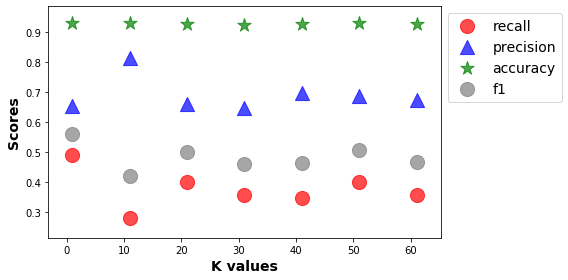

In [26]:
plt.figure(figsize=(8, 4))

list_score = ['recall', 'precision', 'accuracy', 'f1']
list_color = ['r', 'b', 'g', 'grey']
list_marker = ['o', '^', '*', 'o']

df = df_score_knn 

for index, score in enumerate(list_score):
    plt.scatter(df['neighbor'], df[score], marker =list_marker[index], color =list_color[index], s = 200, label = score, alpha = 0.7)
    
plt.legend(loc = 'best', bbox_to_anchor=(1,1), ncol = 1, fontsize = 14)
plt.xlabel('K values', rotation=0, weight='bold', fontsize =14)
plt.ylabel('Scores', rotation=90, weight='bold', fontsize =14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show();

## Tuning - GridSearchCV (can be slow)

Now we are testing something more complicated
* GridSearchCV reports optimized K of 60 for the recall (this is different from the loop process above, but in both approaches, the recall scores are low, only ~ 0.5)

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# choose model
model = KNeighborsClassifier()

# choose grid
grid = dict(n_neighbors=range(1, 100, 10), weights=['uniform', 'distance'])
# grid = dict(n_neighbors=range(1, 100, 10),weights=['uniform', 'distance'],metric=['euclidean', 'manhattan', 'minkowski'])

# choose score
score = 'recall'
# score = make_scorer(fbeta_score, beta=2) # this f-beta may be used for optimize the recall

# grid search and save results
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=2, cv=5, scoring=score, error_score=0, return_train_score=True, verbose=5)
grid_result = grid_search.fit(X, y)

#  - - - summarize - - -
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

print('\nPrint out the mean score, std score, and prameters')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
df = pd.DataFrame(params)
df['model'] = str(model)
df['score_mean'] = means
df['score_std'] = stds
df_summary = df

df.head()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best: 0.488649 using {'n_neighbors': 1, 'weights': 'uniform'}

Print out the mean score, std score, and prameters
0.488649 (0.082870) with: {'n_neighbors': 1, 'weights': 'uniform'}
0.488649 (0.082870) with: {'n_neighbors': 1, 'weights': 'distance'}
0.445405 (0.045044) with: {'n_neighbors': 11, 'weights': 'uniform'}
0.462703 (0.033075) with: {'n_neighbors': 11, 'weights': 'distance'}
0.434595 (0.038314) with: {'n_neighbors': 21, 'weights': 'uniform'}
0.484324 (0.038314) with: {'n_neighbors': 21, 'weights': 'distance'}
0.314595 (0.050983) with: {'n_neighbors': 31, 'weights': 'uniform'}
0.396757 (0.061972) with: {'n_neighbors': 31, 'weights': 'distance'}
0.391351 (0.032360) with: {'n_neighbors': 41, 'weights': 'uniform'}
0.474595 (0.033039) with: {'n_neighbors': 41, 'weights': 'distance'}
0.342703 (0.058777) with: {'n_neighbors': 51, 'weights': 'uniform'}
0.417297 (0.057754) with: {'n_neighbors': 51, 'weights': 'distance'}
0.40

,n_neighbors,weights,model,score_mean,score_std
0,1,uniform,KNeighborsClassifier(),0.489,0.083
1,1,distance,KNeighborsClassifier(),0.489,0.083
2,11,uniform,KNeighborsClassifier(),0.445,0.045
3,11,distance,KNeighborsClassifier(),0.463,0.033
4,21,uniform,KNeighborsClassifier(),0.435,0.038


In [28]:
# Predefine a few functions for plotting
# source: https://www.semicolonworld.com/question/43851/how-to-add-group-labels-for-bar-charts-in-matplotlib

from itertools import groupby

def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos], transform=ax.transAxes, color='black', linewidth=0.5)
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index, level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df):
    ypos = -.1
    scale = 1./df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0

        angle = 90 if level == 10 else 0
        alpha = 0 if level == 10 else 1

        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes, rotation=angle, c= 'black', alpha = alpha)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1


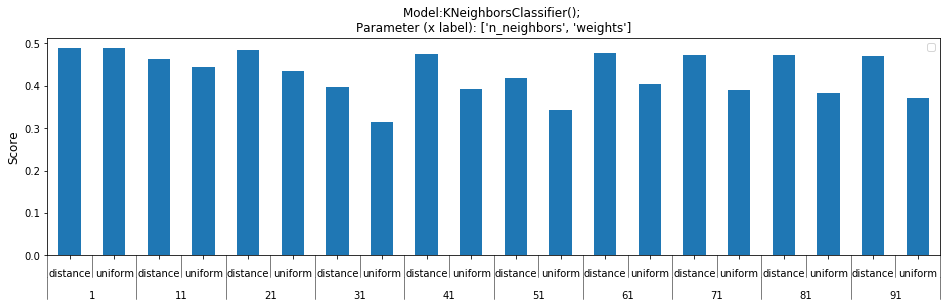

In [29]:
df = df_summary

col_groupby = list(params[0].keys())
col_agg = ['mean']
col_variable, y_label = ['score_mean'], 'Score'

plt.rcParams["figure.figsize"] = (16,4)

df[col_variable] = df[col_variable].astype(float)

df_ave = df.groupby(col_groupby).agg(col_agg)[col_variable]
df_std = df.groupby(col_groupby)[col_variable].std()

ax = df_ave.plot(kind='bar', stacked = True, color = 'tab:blue')
# ax = df_ave.plot(kind='bar', stacked = False, yerr = df_std, error_kw=dict(capsize=3, lw=1, capthick=0.5), edgecolor = "black")

ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, df_ave)

plt.legend('')
# plt.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11, loc='upper left', borderaxespad=0.)
plt.ylabel(y_label, fontsize = 12)
plt.title('Model:' + str(model) + '; \nParameter (x label): ' + str(col_groupby), fontsize = 12)
plt.show();

# Logistic

## Quick fit

For the covid data
* A quick fit of the LogisticRegression gives 0.24 recall, better than dummy but not good
* Regularization affects little on the model performance (because the dataset has been scaled/normalized)

In [30]:
X_train, X_test, y_train, y_test = X_train_copy, X_test_copy, y_train_copy, y_test_copy

In [31]:
lr = LogisticRegression() # C large enough to remove regularization
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('recall: ', round(recall_score(y_test, y_pred), 4))
print('f1:', round(f1_score(y_test, y_pred), 4))

LogisticRegression()

recall:  0.2826
f1: 0.4062


In [32]:
lr = LogisticRegression(C=10000) # C large enough to remove regularization
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('recall: ', round(recall_score(y_test, y_pred), 4))
print('f1:', round(f1_score(y_test, y_pred), 4))

LogisticRegression(C=10000)

recall:  0.2826
f1: 0.4062


## Confusion matrix

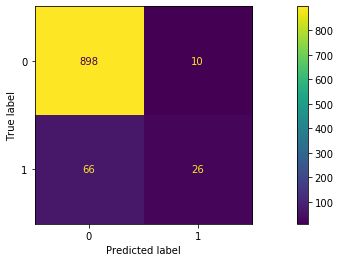

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred) # normalize=None

# plot #1
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.grid(False)

# plot #2
# sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True,
#            xticklabels = target_values,
#            yticklabels = target_values)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion matrix')
# plt.yticks(rotation=0);

## Confusion matrix - interactive
* this is particularly useful in tuning the threshold/probability

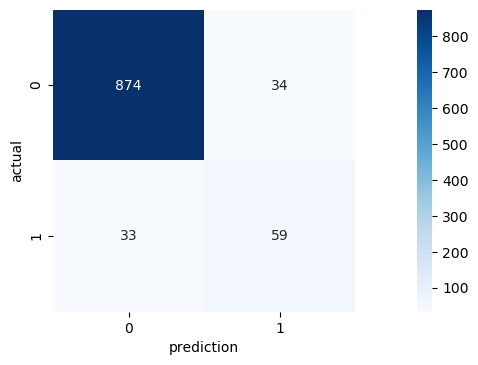

In [34]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
#     fraud_confusion = confusion_matrix(y_test, y_predict, normalize='true')
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', xticklabels=target_values, yticklabels=target_values)
    plt.xlabel('prediction')
    plt.ylabel('actual')
    plt.show();

make_confusion_matrix(lr, threshold = 0.1)

In [35]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(lr, threshold), threshold=(0.0,1,0.1))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0), Output()), _dom_classes=('widg…

## Threshold (*P*) tuning (ROC) (@)
This is very useful for the model tuning: 
    1. Loop through a series of P threshold values
    2. Calculate the corresponding probability (`model.predict_proba(X_test)[:,1]`)
    3. Calculate the model performance (TP, TN, FP, FN, accuracy, recall, precision, f1, etc)
    4. Create a master data frame to store all thresholds and scores
 
 Apart from the scores, we can also plot out
 * ROC curve
 * recall-precision trade off

In [36]:
X_train, X_test, y_train, y_test = X_train_copy, X_test_copy, y_train_copy, y_test_copy

model = LogisticRegression() # C large enough to remove regularization
model.fit(X_train, y_train)

# model = RandomForestClassifier()
# model.fit(X_train, y_train)

thresh_ps = np.linspace(0.01,0.99,1000)

all_scores = []

for p in thresh_ps:
    y_pred = (model.predict_proba(X_test)[:,1] >= p) # positive class probs
    
#     print(type(y_test), type(y_pred))
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

    # calculate the metrics
    TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    ACC = (TP+TN)/(TP+FP+FN+TN)  # Overall accuracy
    
    all_scores.append([p, TN, FP, FN, TP,
                       f1_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred),
                      TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC])
    
all_names = ['threshold', 'TN', 'FP', 'FN', 'TP', 'f1', 'precision', 'recall', 'accuracy', 'TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR', 'ACC']

df = pd.DataFrame(all_scores)
df.columns = all_names

df_score = df

df.head()

LogisticRegression()

,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC
0,0.010,0,908,0,92,0.168,0.092,1.0,0.092,1.0,0.0,0.092,NaN,1.0,0.0,0.908,0.092
1,0.011,0,908,0,92,0.168,0.092,1.0,0.092,1.0,0.0,0.092,NaN,1.0,0.0,0.908,0.092
2,0.012,0,908,0,92,0.168,0.092,1.0,0.092,1.0,0.0,0.092,NaN,1.0,0.0,0.908,0.092
3,0.013,0,908,0,92,0.168,0.092,1.0,0.092,1.0,0.0,0.092,NaN,1.0,0.0,0.908,0.092
4,0.014,0,908,0,92,0.168,0.092,1.0,0.092,1.0,0.0,0.092,NaN,1.0,0.0,0.908,0.092


For covid data
* The best f1 is about 0.68
* The best recall can be reaching 1. However, the threshold is extremely low (~1%) and model accuracy drops to the dummy level (baseline - 9.9%)

In [37]:
df = df_score

print('find the highest f1 score')
df.sort_values(by=['f1'], ascending = False).head(1)

print('find 50% probability')
df.iloc[(df['threshold']-0.5).abs().argsort()[:1]]

print('find the highest recall')
df.sort_values(by=['recall'], ascending = False).head(1)

find the highest f1 score


,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC
101,0.109,877,31,33,59,0.648,0.656,0.641,0.936,0.641,0.966,0.656,0.964,0.034,0.359,0.344,0.936


find 50% probability


,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC
500,0.5,898,10,66,26,0.406,0.722,0.283,0.924,0.283,0.989,0.722,0.932,0.011,0.717,0.278,0.924


find the highest recall


,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC
0,0.01,0,908,0,92,0.168,0.092,1.0,0.092,1.0,0.0,0.092,NaN,1.0,0.0,0.908,0.092


Visualize the change of scores over the threshold

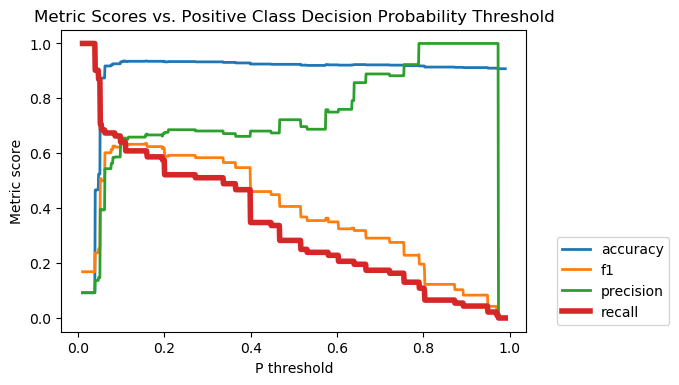

In [38]:
df = df_score
col_plot = ['accuracy', 'f1', 'precision',  'recall']

plt.figure(figsize=(6,4), dpi=100)

for col in col_plot:
    linewidth = 4 if col == 'recall' else 2
#     linestyle = 'dotted' if col == 'recall' else 'solid'
    plt.plot(df['threshold'], df[col], linewidth = linewidth, linestyle = None)
    
plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(col_plot, bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')
plt.show();

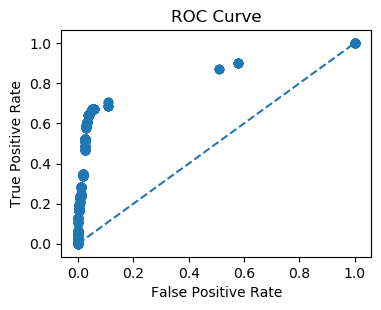

In [39]:
# Visual: precision-recall trade-off

plt.figure(figsize=(4,3), dpi=100)

df = df_score
plt.scatter(df['FPR'], df['TPR'])

x = np.linspace(0,1, 1000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show();

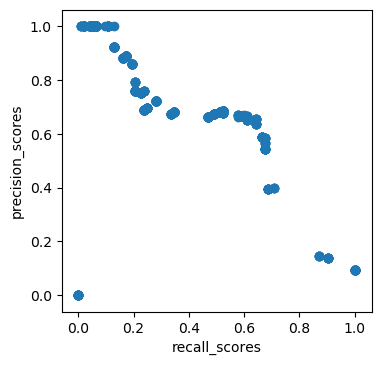

In [40]:
# Visual: precision-recall trade-off
    
plt.figure(figsize=(4,4), dpi=100)

df = df_score

plt.scatter(df['recall'], df['precision'])

# plt.title('precision and recall')
plt.xlabel('recall_scores')
plt.ylabel('precision_scores')

plt.show();

## Feature importance

In [41]:
# get the coeff, log coeff, and probability for the default model

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

print('coefs:', lr_model.coef_[0])

print('exp(coef):', np.exp(lr_model.coef_[0]))

df_coefficients = {'feature': X_train.columns, 
        'coeff (log odd) - log loss': lr_model.coef_[0],
       'proba (odds)': np.exp(lr_model.coef_[0]),
       'proba (% in increase)': ["{:.1%}".format(item-1) for item in np.exp(lr_model.coef_[0])]}

# pd.DataFrame.from_dict(data_coefficients).head()
pd.DataFrame.from_dict(df_coefficients).sort_values(by=['proba (odds)'], ascending = False)

LogisticRegression()

coefs: [0.706121   0.82894737 1.50720167 1.34768876 1.53885593 0.19760287
 0.27665569 2.79011111 0.05858537]
exp(coef): [ 2.02611668  2.29090599  4.51408122  3.84852039  4.65925672  1.21847841
  1.31871225 16.28282884  1.0603355 ]


,feature,coeff (log odd) - log loss,proba (odds),proba (% in increase)
7,contact_with_confirmed,2.790,16.283,1528.3%
4,head_ache,1.539,4.659,365.9%
2,sore_throat,1.507,4.514,351.4%
3,shortness_of_breath,1.348,3.849,284.9%
1,fever,0.829,2.291,129.1%
0,cough,0.706,2.026,102.6%
6,gender,0.277,1.319,31.9%
5,age_60_and_above,0.198,1.218,21.8%
8,abroad,0.059,1.060,6.0%


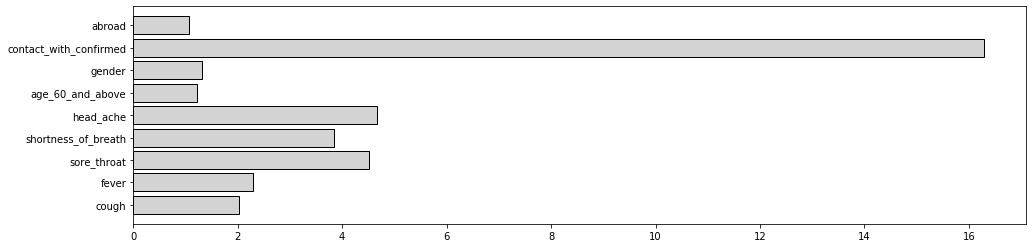

In [42]:
df = df_coefficients
plt.barh(df['feature'], width=df['proba (odds)'], color = 'lightgrey', edgecolor = 'black');

## Feature importance (bootstrapped)
* The bootstrapping process is used to generate "extra" bags of datasets and estimate the variation of the coefficients / feature importance
* `df_coef`: the data frame that stores all fitted logistic-regression coefficients
* `df_coef`: # of rows = # of bags, # of columns = # feature + 1 (1 here is the intercept)
* `df_CI`: the data frame that stores all the confidence intervals (lower-mean-upper) for the logistic-regression coefficients

In [43]:
df_train = X_train.copy()
df_train[col_y] = y_train.copy()

# adjust as needed
bags, samples = 1000, 10000
# samples = X_train.shape[0]

df_coef = pd.DataFrame()

show_progress = 0

for index, item in enumerate(range(bags)):
    
    progress = index/bags
    if progress < show_progress: pass
    else: print('Progress:', "{:.0%}".format(show_progress)); show_progress = show_progress + 0.1    
    
    # bootstrap with replacement enabled
    df_bootstrap = df_train.sample(n=samples, replace=True)

    X_sample = np.array(df_bootstrap[col_X])
    y_sample = np.array(df_bootstrap[col_y])
    
    model = LogisticRegression().fit(X_sample, y_sample)
    coefficients = list(model.coef_[0]) + list([model.intercept_][0])

    df_temp = pd.DataFrame([coefficients])
    df_coef  = pd.concat([df_coef, df_temp])
    
df_coef.columns = list(X_train.columns) + ['intercept']
df_coef = df_coef.reset_index(drop=True)

# df_coef.to_excel('data/' + 'df_coeff_100000samples_1000bags_LogisticRegression.xlsx')

df_coef.shape
df_coef.head()

Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%


(1000, 10)

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_60_and_above,gender,contact_with_confirmed,abroad,intercept
0,0.657,0.834,2.286,2.705,1.477,0.130,0.287,2.723,0.127,-3.218
1,0.974,0.589,1.438,1.164,1.090,0.124,0.335,2.772,-1.169,-3.202
2,0.976,0.556,1.933,0.604,1.794,0.214,0.241,2.970,0.073,-3.215
3,0.956,0.995,1.039,0.195,1.736,0.237,0.346,2.872,0.047,-3.252
4,0.561,0.857,1.688,0.996,1.467,0.184,0.222,2.824,0.016,-3.104


In [44]:
# df_CI: confidence internval

df = pd.DataFrame()

list_mean = []
list_lower = []
list_upper = []

for col in df_coef.columns:
    data = df_coef[col]
    a, b, c = np.percentile(data, 2.5), np.mean(data), np.percentile(data, 97.5)
    print('col_name:', col, '; percentiles:', round(a, 4), round(b, 4), round(c, 4))
    list_lower.append(np.percentile(data, 2.5))
    list_mean.append(np.mean(data))
    list_upper.append(np.percentile(data, 97.5))
    
df['feature'] = df_coef.columns
df['lower'] = list_lower
df['lower_exp'] = [np.exp(item) for item in list_lower]
df['lower_prob'] = ["{:.0%}".format(np.exp(item)-1) for item in list_lower]
df['mean'] = list_mean
df['mean_exp'] = [np.exp(item) for item in list_mean]
df['mean_prob'] = ["{:.0%}".format(np.exp(item)-1) for item in list_mean]
df['upper'] = list_upper
df['upper_exp'] = [np.exp(item) for item in list_upper]
df['upper_prob'] = ["{:.0%}".format(np.exp(item)-1) for item in list_upper]
df['interval'] = (df['upper'] - df['lower'])/2
df['interval_exp'] = (df['upper_exp'] - df['lower_exp'])/2
df['interval_prob'] = [ ((np.exp(list_upper[index])-1) -  (np.exp(list_lower[index])-1))/2  for index, item in enumerate(list_upper)]

# remove the intercept row and rank
df = df[~(df['feature'].str.contains('intercept'))]
df = df.sort_values(by=['mean'], ascending = True)

df_CI = df

df.head(10)

col_name: cough ; percentiles: 0.31 0.7001 1.0698
col_name: fever ; percentiles: 0.4421 0.8182 1.1742
col_name: sore_throat ; percentiles: 0.876 1.5339 2.1797
col_name: shortness_of_breath ; percentiles: 0.4538 1.3849 2.273
col_name: head_ache ; percentiles: 1.0564 1.559 2.116
col_name: age_60_and_above ; percentiles: -0.0278 0.1988 0.4097
col_name: gender ; percentiles: 0.1112 0.2749 0.4429
col_name: contact_with_confirmed ; percentiles: 2.6076 2.8096 3.0159
col_name: abroad ; percentiles: -0.6548 0.0477 0.6866
col_name: intercept ; percentiles: -3.344 -3.2077 -3.0729


,feature,lower,lower_exp,lower_prob,mean,mean_exp,mean_prob,upper,upper_exp,upper_prob,interval,interval_exp,interval_prob
8,abroad,-0.655,0.520,-48%,0.048,1.049,5%,0.687,1.987,99%,0.671,0.734,0.734
5,age_60_and_above,-0.028,0.973,-3%,0.199,1.220,22%,0.410,1.506,51%,0.219,0.267,0.267
6,gender,0.111,1.118,12%,0.275,1.316,32%,0.443,1.557,56%,0.166,0.220,0.220
0,cough,0.310,1.363,36%,0.700,2.014,101%,1.070,2.915,191%,0.380,0.776,0.776
1,fever,0.442,1.556,56%,0.818,2.266,127%,1.174,3.236,224%,0.366,0.840,0.840
3,shortness_of_breath,0.454,1.574,57%,1.385,3.994,299%,2.273,9.709,871%,0.910,4.067,4.067
2,sore_throat,0.876,2.401,140%,1.534,4.636,364%,2.180,8.844,784%,0.652,3.221,3.221
4,head_ache,1.056,2.876,188%,1.559,4.754,375%,2.116,8.298,730%,0.530,2.711,2.711
7,contact_with_confirmed,2.608,13.566,1257%,2.810,16.603,1560%,3.016,20.408,1941%,0.204,3.421,3.421


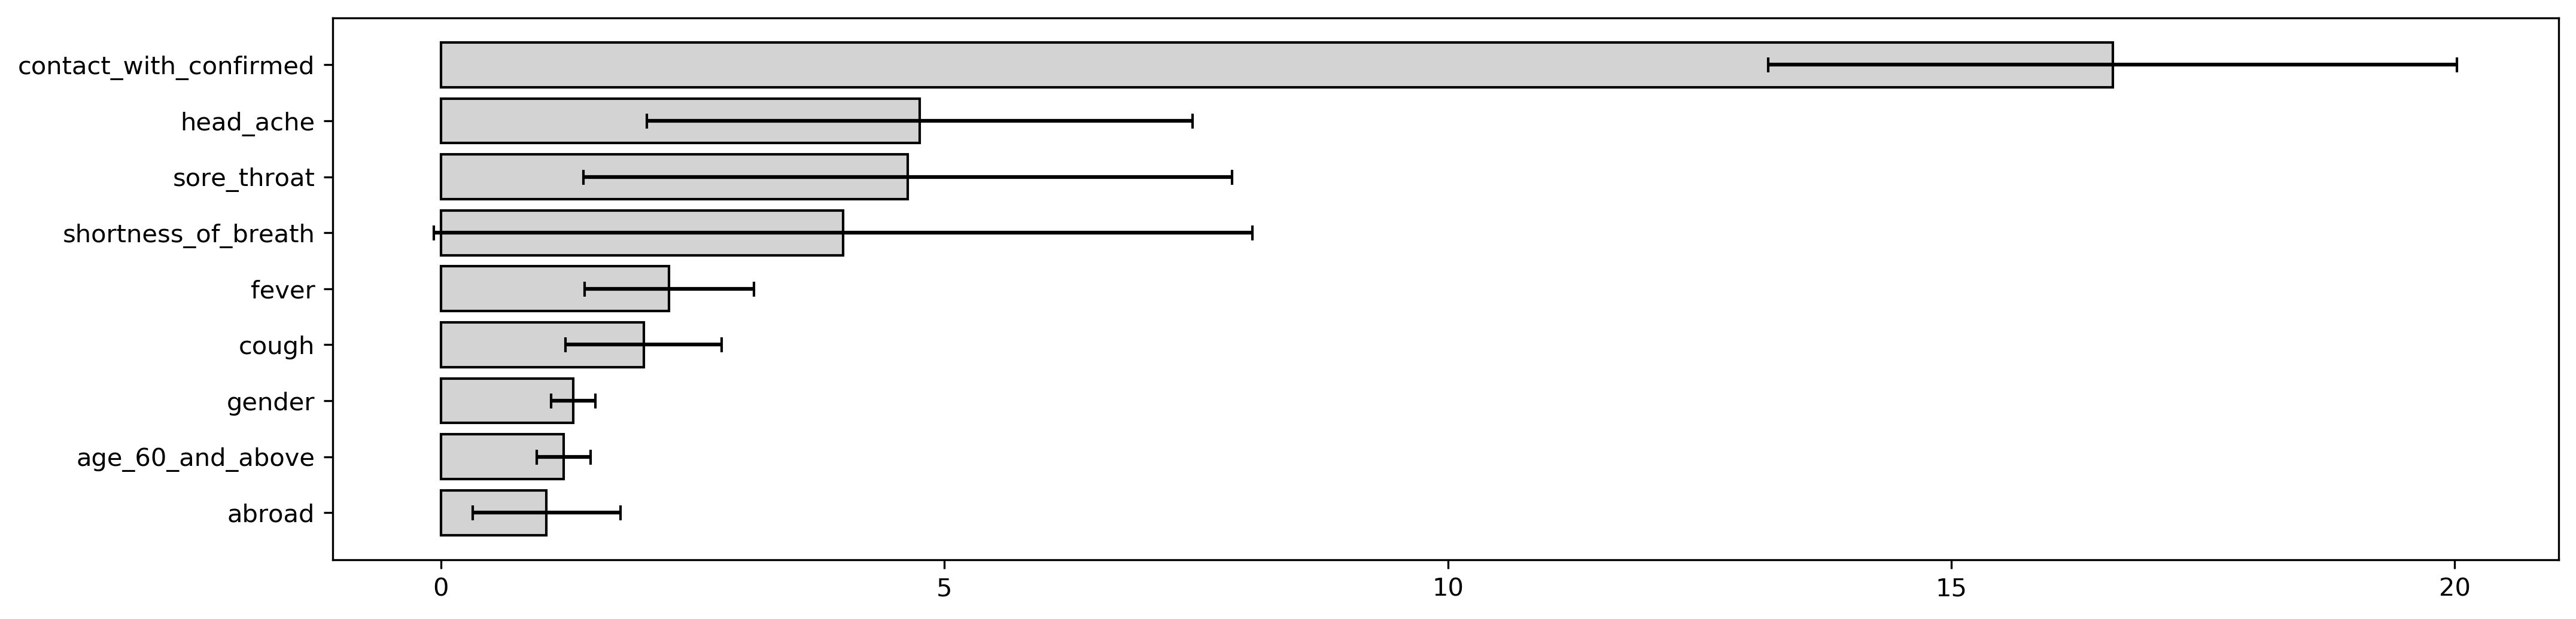

In [45]:
df = df_CI

# for tigher error bars, need to increase the bad/sample size
# speed is not a big concern for this study

plt.figure(dpi=300)
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["errorbar.capsize"] = 3

# plt.barh(df['feature'], width=df['mean'], xerr = df['interval'], color = 'lightgrey', edgecolor = 'black')
plt.barh(df['feature'], width=df['mean_exp'], xerr = df['interval_exp'], color = 'lightgrey', edgecolor = 'black')
# plt.barh(df['feature'], width=df['mean_prob'], xerr = df['interval_prob'], color = 'lightgrey', edgecolor = 'black')
# plt.xlim([0,15])
plt.xticks([0, 5, 10, 15, 20])
plt.show();

# Random Forest

## Quick fit and check score

In [46]:
# check input data again
X, y = X_copy, y_copy
X_train, X_test, y_train, y_test = X_train_copy, X_test_copy, y_train_copy, y_test_copy
print(X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

(10000, 9) (8000, 9) (1000, 9) (10000, 1) (8000, 1) (1000, 1)


In [47]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('recall: ', round(recall_score(y_pred, y_test), 4))
print('f1:', round(f1_score(y_pred, y_test), 4))
confusion_matrix(y_test, y_pred)

RandomForestClassifier()

recall:  0.6923
f1: 0.5732


array([[888,  20],
       [ 47,  45]], dtype=int64)

## Tuning - GridSearchCV

For the covid data
* It seems that the selected pamaters do not make a big difference on the recall score (always about 50%)

In [48]:
model = RandomForestClassifier()

score = 'recall'
grid = dict(n_estimators=[10, 100, 1000], max_features=['sqrt', 'log2'], bootstrap = [True, False])

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=5, scoring=score, error_score=0, return_train_score=True, verbose=3)

grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

df = pd.DataFrame(params)
df['model'] = str(model)
df['score_mean'] = means
df['score_std'] = stds
df_summary = df

df.head()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best: 0.502703 using {'bootstrap': True, 'max_features': 'log2', 'n_estimators': 1000}


,bootstrap,max_features,n_estimators,model,score_mean,score_std
0,True,sqrt,10,RandomForestClassifier(),0.488,0.044
1,True,sqrt,100,RandomForestClassifier(),0.502,0.043
2,True,sqrt,1000,RandomForestClassifier(),0.498,0.037
3,True,log2,10,RandomForestClassifier(),0.483,0.041
4,True,log2,100,RandomForestClassifier(),0.490,0.040


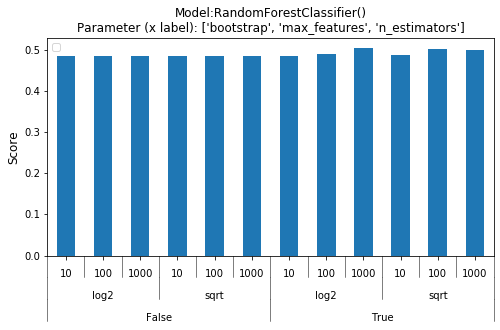

In [49]:
df = df_summary

col_groupby = list(params[0].keys())
col_agg = ['mean']
col_variable, y_label = ['score_mean'], 'Score'

plt.rcParams["figure.figsize"] = (8,4)

df[col_variable] = df[col_variable].astype(float)

df_ave = df.groupby(col_groupby).agg(col_agg)[col_variable]
df_std = df.groupby(col_groupby)[col_variable].std()

ax = df_ave.plot(kind='bar', stacked = True, color = 'tab:blue')
# ax = df_ave.plot(kind='bar', stacked = False, yerr = df_std, error_kw=dict(capsize=3, lw=1, capthick=0.5), edgecolor = "black")

ax.set_xticklabels('')
ax.set_xlabel('')
label_group_bar_table(ax, df_ave)

plt.legend('')
# plt.legend(bbox_to_anchor=(1.05, 0.8), fontsize = 11, loc='upper left', borderaxespad=0.)
plt.ylabel(y_label, fontsize = 12)
plt.title('Model:' + str(model) + '\nParameter (x label): ' + str(col_groupby), fontsize = 12)
plt.show();

## Feature importance

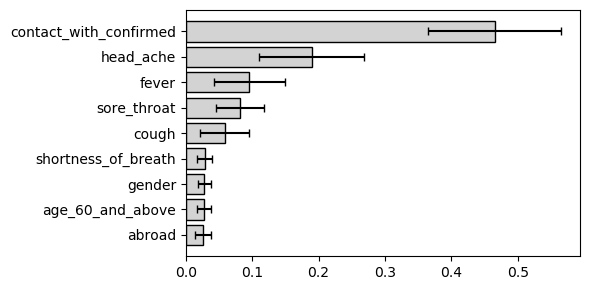

In [50]:
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (6,3)
plt.rcParams["errorbar.capsize"] = 3

feature_names = X_train.columns
forest = RandomForestClassifier(random_state=0)
# forest = RandomForestClassifier(random_state=0, n_estimators=1000, max_features='sqrt')
forest.fit(X_train, y_train)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
df_forest_importances = pd.DataFrame(importances, index=feature_names, columns=['importance'])
df_forest_importances['std'] = std
df_forest_importances['feature'] = df_forest_importances.index
df_forest_importances = df_forest_importances.sort_values(by =['importance'], ascending = True)
plt.barh(df_forest_importances['feature'], width=df_forest_importances['importance'], xerr = df_forest_importances['std'], color = 'lightgrey', edgecolor = 'black')
plt.tight_layout()
plt.show();

#  Compare models (Score & ROC)

## LR vs KNN
* TM: using the covid data, a reshape of `.reshape(-1,1)` is needed for data feeding

In [51]:
# check input data again
X_train, X_test, y_train, y_test = X_train_copy, X_test_copy, y_train_copy, y_test_copy
print(X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)
print(X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

(10000, 9) (8000, 9) (1000, 9) (10000, 1) (8000, 1) (1000, 1)
(10000, 9) (8000, 9) (1000, 9) (10000, 1) (8000, 1) (1000, 1)


In [52]:
model1 = LogisticRegression(C=10000) # C large enough to remove regularization
model1.fit(X_train, y_train)
model1_name = 'LogisticRegression (P=0.079)'

model2 = KNeighborsClassifier(n_neighbors=30) # the neighbor of 30 has been optimized for recall
model2.fit(X_train, y_train)
model2_name = '30-NN'

# y_pred = lr.predict(X_test).reshape(-1,1)
y_pred =model1.predict_proba(X_test)[:,1] >= 0.079 # note that this is the LogisticRegression with optimized threshold
print(model1_name + ' validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_test, y_pred), 
         precision_score(y_test, y_pred), 
         recall_score(y_test, y_pred), 
         f1_score(y_test, y_pred), 
        )
     )

print('\n')

y_pred = model2.predict(X_test).reshape(-1,1)
print(model2_name + ' validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
        (accuracy_score(y_test, y_pred), 
         precision_score(y_test, y_pred), 
         recall_score(y_test, y_pred), 
         f1_score(y_test, y_pred), 
        )
     )

LogisticRegression(C=10000)

KNeighborsClassifier(n_neighbors=30)

LogisticRegression (P=0.079) validation metrics: 
 Accuracy: 0.9220 
 Precision: 0.5636 
 Recall: 0.6739 
 F1: 0.6139


30-NN validation metrics: 
 Accuracy: 0.9240 
 Precision: 0.6600 
 Recall: 0.3587 
 F1: 0.4648


Compare ROC

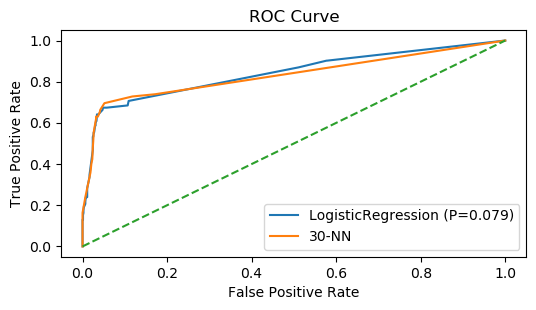

In [53]:
from sklearn.metrics import roc_curve

# first model: lr
fpr, tpr, _ = roc_curve(y_test, model1.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

# second model: knn
fpr, tpr, _ = roc_curve(y_test, model2.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend([model1_name, model2_name])

plt.show();

## LR:Simple vs Resampled (Class imbalance)

Covid data
* Since the data is imbalanced, Let us see is resampling can help improve the model performance 
* 2 models are compared here: simple logistic regression, oversampled logistic regression (note that the test dataset is not modified at all during the resampling and used for estimating the model performance)
* Usually, we may not see a big different in the ROC curve, but the f1 and recall scores (at 50% threshold) has been improved significantly

In [54]:
print('Check data:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(y_train))

n_pos = y_train[y_train[col_y] == 1].dropna().shape[0]
n_neg = y_train[y_train[col_y] == 0].dropna().shape[0]

Check data:
(8000, 9) (1000, 9) (8000, 1) (1000, 1)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [55]:
import imblearn.over_sampling

# setup for the ratio argument of RandomOverSampler initialization
ratio = {1 : n_pos * 4, 0 : n_neg} 
print('n_pos =', n_pos, ', n_neg =', n_neg)

# randomly oversample positive samples: create nx as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

# simple regression model
model1 = LogisticRegression(solver='liblinear') 
model1.fit(X_train, y_train)
model1_name = 'Simple Logistic Regression'

print(model1_name)
print('Test F1: %.3f' % f1_score(y_test, model1.predict(X_test)))
print('Test Recall: %.3f' % recall_score(y_test, model1.predict(X_test)))
print('Test AUC: %.3f' % roc_auc_score(y_test, model1.predict_proba(X_test)[:,1]))

model2 = LogisticRegression(solver='liblinear') 
model2.fit(X_train_rs, y_train_rs)
model2_name = 'Logistic Regression on Oversampled Train Data'

print(model2_name)
print('Test F1: %.3f' % f1_score(y_test, model2.predict(X_test)))
print('Test Recall: %.3f' % recall_score(y_test, model2.predict(X_test)))
print('Test AUC: %.3f' % roc_auc_score(y_test, model2.predict_proba(X_test)[:,1]))

n_pos = 735 , n_neg = 7265


LogisticRegression(solver='liblinear')

Simple Logistic Regression
Test F1: 0.406
Test Recall: 0.283
Test AUC: 0.841


LogisticRegression(solver='liblinear')

Logistic Regression on Oversampled Train Data
Test F1: 0.636
Test Recall: 0.609
Test AUC: 0.833


In [56]:
thresh_ps = np.linspace(0.01,0.99,100)

all_models = [model1, model2]
all_modelnames = [model1_name, model2_name]

df = pd.DataFrame()
for index, model in enumerate(all_models):
    print(model)
    y_predict_probs = model.predict_proba(X_test)[:,1] # positive class probs, same basic logistic model we fit in section 2 
    for p in thresh_ps:      
        y_predict = y_predict_probs >= p

        TN, FP, FN, TP = confusion_matrix(y_test, y_predict).ravel()

        # calculate the metrics
        TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
        TNR = TN/(TN+FP) # Specificity or true negative rate
        PPV = TP/(TP+FP) # Precision or positive predictive value
        NPV = TN/(TN+FN) # Negative predictive value
        FPR = FP/(FP+TN) # Fall out or false positive rate
        FNR = FN/(TP+FN) # False negative rate
        FDR = FP/(TP+FP) # False discovery rate
        ACC = (TP+TN)/(TP+FP+FN+TN)  # Overall accuracy

        all_scores = []
        all_scores.append([p, TN, FP, FN, TP,
                           f1_score(y_test, y_predict), precision_score(y_test, y_predict), 
                           recall_score(y_test, y_predict), accuracy_score(y_test, y_predict),
                          TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC])

        df_temp = pd.DataFrame(all_scores)
        df_temp['model'] = all_modelnames[index]
        df = pd.concat([df, df_temp])
        
all_names = ['threshold', 'TN', 'FP', 'FN', 'TP', 'f1', 'precision', 'recall', 'accuracy', 'TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR', 'ACC', 'model']
df.columns = all_names

df_score = df

df = df_score
df.head()

LogisticRegression(solver='liblinear')
LogisticRegression(solver='liblinear')


,threshold,TN,FP,FN,TP,f1,precision,recall,accuracy,TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC,model
0,0.01,0,908,0,92,0.168,0.092,1.00,0.092,1.00,0.000,0.092,NaN,1.000,0.00,0.908,0.092,Simple Logistic Regression
0,0.02,0,908,0,92,0.168,0.092,1.00,0.092,1.00,0.000,0.092,NaN,1.000,0.00,0.908,0.092,Simple Logistic Regression
0,0.03,0,908,0,92,0.168,0.092,1.00,0.092,1.00,0.000,0.092,NaN,1.000,0.00,0.908,0.092,Simple Logistic Regression
0,0.04,0,908,0,92,0.168,0.092,1.00,0.092,1.00,0.000,0.092,NaN,1.000,0.00,0.908,0.092,Simple Logistic Regression
0,0.05,444,464,12,80,0.252,0.147,0.87,0.524,0.87,0.489,0.147,0.974,0.511,0.13,0.853,0.524,Simple Logistic Regression


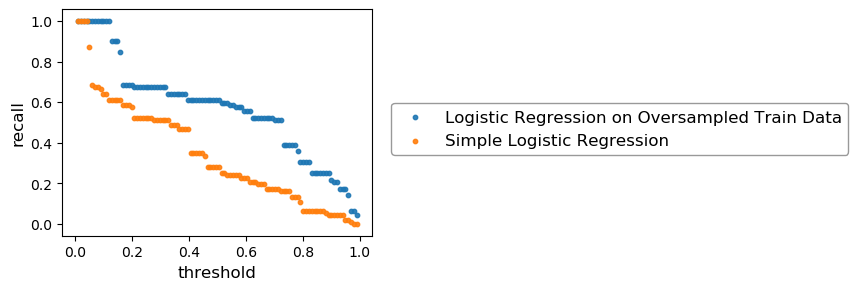

In [57]:
df = df_score

col_groupby = ['model']

x, y = 'threshold', 'recall'
x_label, y_label = x, y 

plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (4,3)
for index, (name, group) in enumerate(df.groupby(col_groupby)):
    plt.scatter(group[x], group[y], label = name,  s = 10, alpha = 0.9) # , marker=["^", "o", "s"][index], s = 5000000* group['T2_Alumina_AF'], 

plt.legend(bbox_to_anchor=(1.05, 0.6), fontsize = 12, loc='upper left', borderaxespad=0.2, edgecolor = 'grey')
plt.xlabel(x_label, fontsize = 12)
plt.ylabel(y_label, fontsize = 12)
plt.show();

## LR: without and with *class_weight* (Class imbalance)

* Similar to the 

In [58]:
lr = LogisticRegression(solver='liblinear') 
lr_balanced = LogisticRegression(class_weight='balanced', solver='liblinear')
lr_4x = LogisticRegression(class_weight={1 : 4, 0 : 1}, solver='liblinear')

lr.fit(X_train, y_train)
print('Normal Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr.predict(X_test)), roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])))

lr_balanced.fit(X_train, y_train)
print('Balanced class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_balanced.predict(X_test)), roc_auc_score(y_test, lr_balanced.predict_proba(X_test)[:,1])))

lr_4x.fit(X_train, y_train)
print('4:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_4x.predict(X_test)), roc_auc_score(y_test, lr_4x.predict_proba(X_test)[:,1])));

Normal Logistic Regression Test F1: 0.406, Test AUC: 0.841
Balanced class weights Logistic Regression Test F1: 0.614, Test AUC: 0.842
4:1 class weights Logistic Regression Test F1: 0.633, Test AUC: 0.841


## Gradient boost: without and with oversampling

Oversampling improves the recall from 0.61 to 0.68
* X_train, y_train: without oversampling
* X_train_os, y_train_os: oversampled
* Again: the test dataset is not resampled at all!, so that the model performance is comparable

In [59]:
# !conda install -y -c conda-forge xgboost

import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
import xgboost as xgb

X_train, X_test, y_train, y_test = X_train_copy, X_test_copy, y_train_copy, y_test_copy
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8000, 9) (1000, 9) (8000, 1) (1000, 1)


In [60]:
# regular XGBoost model

gbm = xgb.XGBClassifier( n_estimators=30000, max_depth=4, objective='binary:logistic', learning_rate=.05, 
                        subsample=.8, min_child_weight=3, colsample_bytree=.8)

eval_set=[(X_train,y_train),(X_test,y_test)]

fit_model = gbm.fit(X_train, y_train, eval_set=eval_set,eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50, verbose=10)

print('accuracy:', accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))
print('recall:', recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))

[0]	validation_0-error:0.07025	validation_1-error:0.06400
[10]	validation_0-error:0.07612	validation_1-error:0.06800
[20]	validation_0-error:0.07575	validation_1-error:0.07300
[30]	validation_0-error:0.07525	validation_1-error:0.06900
[40]	validation_0-error:0.07200	validation_1-error:0.06900
[49]	validation_0-error:0.06950	validation_1-error:0.06500
accuracy: 0.936
recall: 0.5652173913043478


In [61]:
# XGBoost model with oversampling

import imblearn.over_sampling
n_pos = y_train[y_train[col_y] == 1].dropna().shape[0]
n_neg = y_train[y_train[col_y] == 0].dropna().shape[0]
ratio = {1 : n_pos * 4, 0 : n_neg} 
print('n_pos =', n_pos, ', n_neg =', n_neg)

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
X_train_rs, y_train_rs = ROS.fit_resample(X_train, y_train)

gbm = xgb.XGBClassifier( n_estimators=30000, max_depth=4, objective='binary:logistic', learning_rate=.05, 
                        subsample=.8, min_child_weight=3, colsample_bytree=.8)

eval_set=[(X_train_rs,y_train_rs),(X_test,y_test)]

fit_model = gbm.fit(X_train_rs, y_train_rs,  eval_set=eval_set,eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50, verbose=10)

print('accuracy:', accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))
print('recall:', recall_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)))

n_pos = 735 , n_neg = 7265
[0]	validation_0-error:0.14473	validation_1-error:0.06400
[10]	validation_0-error:0.14238	validation_1-error:0.06100
[20]	validation_0-error:0.13944	validation_1-error:0.06100
[30]	validation_0-error:0.13944	validation_1-error:0.06100
[40]	validation_0-error:0.13964	validation_1-error:0.06100
[50]	validation_0-error:0.13964	validation_1-error:0.06100
accuracy: 0.939
recall: 0.6413043478260869


In [62]:
gbm = xgb.XGBClassifier( n_estimators=30000, max_depth=4, objective='binary:logistic', learning_rate=.05, 
                        subsample=.8, min_child_weight=3, colsample_bytree=.8)

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm.fit(X_train_rs, y_train_rs,  eval_set=eval_set,eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50, verbose=10)

model = gbm
model_final = gbm

# model = RandomForestClassifier()
# model.fit(X_train, y_train)

thresh_ps = np.linspace(0.01,0.99,1000)
y_predict_probs = model.predict_proba(X_test)[:,1] # positive class probs, same basic logistic model we fit in section 2 

all_scores = []

for p in thresh_ps:
    y_pred = y_predict_probs >= p
    
#     print(type(y_test), type(y_pred))
    
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

    TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    ACC = (TP+TN)/(TP+FP+FN+TN)  # Overall accuracy
    
    all_scores.append([p, TN, FP, FN, TP,
                       f1_score(y_test, y_pred), precision_score(y_test, y_pred),
                       recall_score(y_test, y_pred), accuracy_score(y_test, y_pred),
                      TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC])

all_names = ['threshold', 'TN', 'FP', 'FN', 'TP', 'f1', 'precision', 'recall', 'accuracy', 'TPR', 'TNR', 'PPV', 'NPV', 'FPR', 'FNR', 'FDR', 'ACC']

df = pd.DataFrame(all_scores)
df.columns = all_names

df_score = df

[0]	validation_0-error:0.07550	validation_1-error:0.06400
[10]	validation_0-error:0.07250	validation_1-error:0.06100
[20]	validation_0-error:0.07250	validation_1-error:0.06100
[30]	validation_0-error:0.07250	validation_1-error:0.06100
[40]	validation_0-error:0.07275	validation_1-error:0.06100
[50]	validation_0-error:0.07275	validation_1-error:0.06100


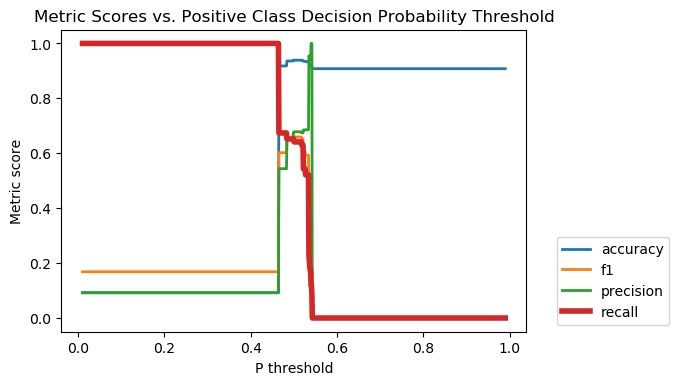

In [63]:
df = df_score
col_plot = ['accuracy', 'f1', 'precision',  'recall']

plt.figure(figsize=(6,4), dpi=100)

for col in col_plot:
    linewidth = 4 if col == 'recall' else 2
    plt.plot(df['threshold'], df[col], linewidth = linewidth, linestyle = None)
    
plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(col_plot, bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')
plt.show();

# - - - Part 4: Final model - - - 

# Final model
* Moment of Turth!

In order to optimize the model performance (particularly the recall)
* We tested multiple classification models: KNN, LR, Tree, Forest, NaiveBayes, SVC, Ensemble, Boost
* We used the GridSearchCV to find the best parameters
* We examined the threshold adjustment
* We used class imbalance (oversampling and class_weight)

This is what we have observed:
* All models report a ~ 0.6 recall unless we sacrifice significantly on the accuracy

At the last, we will test this on the holdout dataset

accuracy: 0.905
precision: 0.514
recall: 0.551
f1: 0.532


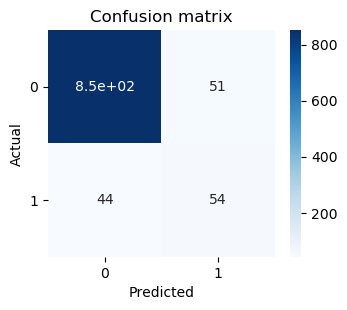

In [64]:
model_final = LogisticRegression()
model_final.fit(X_train, y_train)

y_pred = (model_final.predict_proba(X_holdout)[:, 1] >= 0.1)

confusion_matrix(y_holdout, y_pred)

print('accuracy:', round(accuracy_score(y_holdout, y_pred), 3))
print('precision:', round(precision_score(y_holdout, y_pred), 3))
print('recall:', round(recall_score(y_holdout, y_pred), 3))
print('f1:', round(f1_score(y_holdout, y_pred), 3))

sns.heatmap(confusion_matrix(y_holdout, y_pred), cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels = target_values,
           yticklabels = target_values)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')
plt.yticks(rotation=0);